In [60]:
import sim          # Library for coppelia communication       
import sympy as sp  # Library to work with symbolic variables
from scipy import optimize
import numpy as np
from matplotlib import pyplot as plt

In [64]:
# Function to calculate symbolic denavit transformations from parameters

def symTfromDH(theta, d, a, alpha):

    Rz = sp.Matrix([[sp.cos(theta), -sp.sin(theta), 0, 0],
                   [sp.sin(theta), sp.cos(theta), 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    tz = sp.Matrix([[1, 0, 0, 0],
                   [0, 1, 0, 0],
                   [0, 0, 1, d],
                   [0, 0, 0, 1]])
    ta = sp.Matrix([[1, 0, 0, a],
                   [0, 1, 0, 0],
                   [0, 0, 1, 0],
                   [0, 0, 0, 1]])
    Rx = sp.Matrix([[1, 0, 0, 0],
                   [0, sp.cos(alpha), -sp.sin(alpha), 0],
                   [0, sp.sin(alpha), sp.cos(alpha), 0],
                   [0, 0, 0, 1]])
    T = Rz*tz*ta*Rx
    return T

## Calculate Denavit Transformations

In [67]:
# Robot dimensions
L1 = 300
L2 = 600
L3 = 400

q1 = sp.symbols('q1') # First rotational joint angle
q2 = sp.symbols('q2') # Second rotational joint angle
l1 = sp.symbols('l1') # First prismatic joint length

# Calculated denavit parameters
theta = [0,q1, q2,0]
d = [L1,0,0,l1]
a = [0,L2,L3,0]
alpha = [sp.pi/2,0,sp.pi/2,0]

# Partial transformations to end effector
T01 = symTfromDH(theta[0],d[0],a[0],alpha[0])
T12 = symTfromDH(theta[1],d[1],a[1],alpha[1])
T23 = symTfromDH(theta[2],d[2],a[2],alpha[2])
T34 = symTfromDH(theta[3],d[3],a[3],alpha[3])

# Final tranformation
T04 = T01*T12*T23*T34
T04.simplify()
T04

Matrix([
[cos(q1 + q2),  0,  sin(q1 + q2),        l1*sin(q1 + q2) + 600*cos(q1) + 400*cos(q1 + q2)],
[           0, -1,             0,                                                       0],
[sin(q1 + q2),  0, -cos(q1 + q2), -l1*cos(q1 + q2) + 600*sin(q1) + 400*sin(q1 + q2) + 300],
[           0,  0,             0,                                                       1]])

## Direct Kinematics

In [77]:
# Evaluate end effector transformation
#1.373492839990343 q2 0.010033453033146945 l1 4.003660654923575
values ={     
q1:1.373492839990343,          # (0 , pi)     
q2: 0,         # (-pi/4 , pi/4) 
l1: 4         # (0 , 300mm) 
}

T04.evalf(subs=values)

Matrix([
[ 0.19602584925803,    0, 0.980598728544285, 199.948244172207],
[                0, -1.0,                 0,                0],
[0.980598728544285,    0, -0.19602584925803, 1279.81462514725],
[                0,    0,                 0,              1.0]])

In [70]:
# Evaluate random positions to plot the work volume
N_POINTS = 1000
points = np.zeros([N_POINTS,3])
for i in range(N_POINTS):
    values ={     
    q1:np.random.uniform(0,sp.pi),   #(0 , pi)      
    q2:np.random.uniform(-sp.pi/4,sp.pi/4), #(-pi/4 , pi/4)
    l1:np.random.uniform(0,300),           # (0 , 300mm) 
    }
    points[i,0:3] = (np.array(T04.evalf(subs=values)[0:3,3]).squeeze())

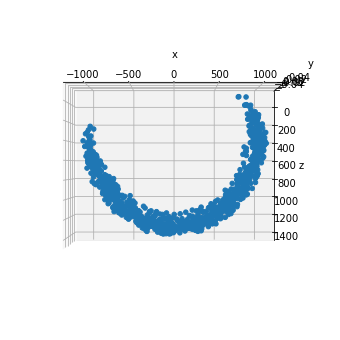

In [73]:
plt.ion()
plt.rcParams['figure.figsize'] = (8,6)
ax =plt.axes(projection='3d')

ax.scatter3D(points[:,0],points[:,1],points[:,2])
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(elev=180,azim=270)


In [19]:
T04

Matrix([
[cos(q1 + q2),  0,  sin(q1 + q2),        l1*sin(q1 + q2) + 600*cos(q1) + 400*cos(q1 + q2)],
[           0, -1,             0,                                                       0],
[sin(q1 + q2),  0, -cos(q1 + q2), -l1*cos(q1 + q2) + 600*sin(q1) + 400*sin(q1 + q2) + 300],
[           0,  0,             0,                                                       1]])

## Inverse Kinematics

In [74]:
# Define end effector postition

X = 200
Y = 0
Z = 1300

def eqs(q):
    q1 = q[0]
    q2 = q[1]
    l1 = q[2]
    f = np.zeros(3)
    f[0] = l1*np.sin(q1 + q2) + 600*np.cos(q1) + 400*np.cos(q1 + q2)  -X
    f[1] = 0 - Y
    f[2] = -l1*np.cos(q1 + q2) + 600*np.sin(q1) + 400*np.sin(q1 + q2)+300 - Z
    return f

In [76]:
q=optimize.fsolve(eqs,[1,1,1])
print(f'q1 {q[0]} q2 {q[1]} l1 {q[2]} ')

q1 1.373492839990343 q2 0.010033453033146945 l1 4.003660654923575 
